In [77]:
import numpy as np
import pandas as pd
import random
import operator
import scipy.stats

from sklearn import model_selection
from sklearn.model_selection import train_test_split

import seaborn as sns
%matplotlib inline

In [78]:
#load data
df = pd.read_csv('../data/breast-cancer-wisconsin.data.txt')

#clean data
df = df.replace('?',-99999)
df = df.astype(float)
df = df.drop(['id'],1)

#shuffle data
df = df.reindex(np.random.permutation(df.index))
df = df.reset_index(drop=True)

#copy data
tf = df.copy()

In [79]:
# prepare configuration for cross validation test harness
seed = 7

X_train, X_test, y_train, y_test = model_selection.train_test_split(tf.iloc[:,:9], 
                                                                    tf.iloc[:,9], 
                                                                    test_size=0.25, 
                                                                    random_state=seed)

In [80]:
class LinearDiscriminantAnalysis(object):
    
    def __init__(self, printing=False, k=2):
        self.printing = printing
        self.k = k
        
    def fit(self,X_train, y_train):
        self.trainSet = pd.concat([X_train, y_train],axis=1)
        self.n_features = X_train.shape[1]
        
        trainSet = self.trainSet
        
        cls_means = self.class_means(trainSet)
        self.within_class(cls_means)
        self.between_class(cls_means)
        
        self.eigen(self.S_W,self.S_B)
        self.transformation_matrix(self.eig_vals, self.eig_vecs)
        self.train_lda = self.transform(trainSet)
        self.class_metrics()
        return 
    
    def class_means(self, dataset):
        class_means = {}
        
        for cls in dataset['class'].unique():
            cls_data = dataset[dataset['class'] == cls]
            mean = cls_data.describe().loc['mean'][:-1]
            class_means[cls] = list(mean.values)
        
        return class_means
    
    def between_class(self, class_means):
        
        """Create between-class scatter matrix"""
        
        trainSet = self.trainSet
        n_features = self.n_features
        
        #vector of overall means
        overall_mean = np.asarray(trainSet.describe().loc['mean'])[:-1]
        overall_mean = overall_mean.reshape(n_features,1)
        
        S_B = np.zeros((n_features,n_features))
        
        for cls in class_means.keys():
            cls_data = trainSet[trainSet['class'] == cls][:-1]
            n = cls_data.shape[0]
            
            cls_mean = np.asarray(class_means[cls])
            cls_mean = cls_mean.reshape(n_features,1)
            
            dif_mean = cls_mean - overall_mean
            
            S_B += n * dif_mean.dot(dif_mean.T)
            
            self.S_B = S_B
            
            return S_B
        
    def within_class(self, class_means):
        
        """Create within-class scatter matrix"""
        
        trainSet = self.trainSet
        n_features = self.n_features
        
        S_W = np.zeros((self.n_features,self.n_features))
        
        for cls in class_means.keys():
            cls_mtrx = np.zeros((n_features,n_features))
            cls_data = np.asarray(trainSet[trainSet['class'] == cls])
            
            for row in cls_data:
                row = row[:-1]
                row = row.reshape(n_features,1)
                
                cls_mean = np.asarray(class_means[cls])
                cls_mean = cls_mean.reshape(n_features,1)
                
                dif_mean = row - cls_mean
                
                cls_mtrx += dif_mean.dot(dif_mean.T)
           
            S_W += cls_mtrx
            
        self.S_W = S_W
           
        return S_W
    
    def eigen(self, mtrx1, mtrx2):
       
        eig_vals, eig_vecs = np.linalg.eig(np.linalg.inv(mtrx1).dot(mtrx2))

        #for i in range(len(eig_vals)):
        #    eigvec_sc = eig_vecs[:,i].reshape(self.n_features,1)   
        #    print('\nEigenvector {}: \n{}'.format(i+1, eigvec_sc.real))
        #    print('Eigenvalue {:}: {:.2e}'.format(i+1, eig_vals[i].real))
            
        self.eig_vals = eig_vals
        self.eig_vecs = eig_vecs
            
        return eig_vals, eig_vecs
    
    def transformation_matrix(self, eig_vals, eig_vecs):
        k = self.k
        printing = self.printing
        n_features = self.n_features 
        eigv_sum = sum(eig_vals)
        
        # Make a list of (eigenvalue, eigenvector) tuples
        eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]

        # Sort the (eigenvalue, eigenvector) tuples from high to low
        eig_pairs = sorted(eig_pairs, key=lambda k: k[0], reverse=True)
        
        #choose k eigenvectors with the largest eigenvalues
        top_eig_vecs = []
        
        for i in range(k):
            ev = eig_pairs[i][1].reshape(n_features,1)
            top_eig_vecs.append(ev)
        
        #create transformation matrix
        W = np.hstack(top_eig_vecs)
        self.W = W
        
        #printing options
        if printing:
            # Visually confirm that the list is correctly sorted by decreasing eigenvalues
            print('Eigenvalues in decreasing order:\n')
            for i in eig_pairs:
                print(i[0])
            
            #variance summary
            print('\nVariance explained:\n')
            for i,j in enumerate(eig_pairs):
                print('eigenvalue {0:}: {1:.2%}'.format(i+1, (j[0]/eigv_sum).real))
            
            #transformation matrix
            print('Matrix W:\n', W.real)
            
        return W
    
    #project to k feature dimensions (i.e. k linear discriminants)
    def transform(self, dataset):
        printing = self.printing
        n_features = self.n_features
        W = self.W
        
        dataset = dataset.iloc[:,:n_features]
        
        lda_matrix = dataset.dot(W)
        
        if printing:
            print(lda_matrix)
        
        return lda_matrix
    
    
    ##PREDICTION
    
    #find gaussian probability
    def gaussian_probability(self, x, mean, std):
        probability = scipy.stats.norm(mean, std).pdf(x)
        return probability
    
    def class_metrics(self):
        """Retrieves mean and stdev for each linear discriminant for each class in training data"""
        train_lda = self.train_lda
        cls_vals = self.trainSet.iloc[:,9].astype('int')
        df = pd.concat([train_lda, cls_vals], axis=1) 
        
        class_metrics = {}
        
        #for each class...
        for cls in cls_vals.unique():
            class_metrics[cls] = 1
            
            data = df[df['class'] == cls]
            data = data.drop('class',axis=1)
            lda_cls_mean = data.describe().loc['mean'].values
            lda_cls_stdev = data.describe().loc['std'].values
            
            class_metrics[cls] = [lda_cls_mean, lda_cls_stdev]
            
        self.class_metrics = class_metrics
        
        return class_metrics

In [81]:
LDA = LinearDiscriminantAnalysis()
LDA.fit(X_train, y_train)
lda = LDA.transform(X_train)

### Plot Projection

C:\Users\Will\Anaconda2\envs\py35\lib\site-packages\numpy\core\numeric.py:583: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


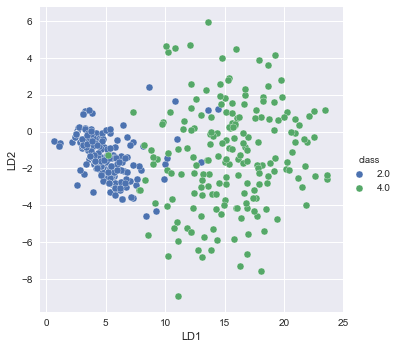

In [82]:
#cls_vals = y_train.astype('int')
cls_vals = y_train

df = pd.concat([lda, cls_vals], axis=1)
df.columns = ['LD1','LD2','class']

sns.pairplot(x_vars=["LD1"], y_vars=["LD2"], data=df, 
hue="class", size=5)